### 📚 Importing Libraries
---

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scikeras.wrappers import KerasClassifier
from keras.layers import Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import math
import cv2
import os

### 📁 Data Directory Setup
---

In [30]:
# local directory (for vscode)
image_path_train = 'mood-images-large/train'
image_path_test = 'mood-images-large/test'

images_small = 'mood-images-small'

# drive folder (for google colab)
# from google.colab import drive
# drive.mount('/content/drive')
# image_set_path = '/content/drive/My Drive/dataset/mood-images'

### 📱 MobileNet Model Setup
---

In [32]:
# base_model = MobileNet(input_shape=(224,224,3), include_top=False)

# for layer in base_model.layers:
#     layer.trainable = False

# x = base_model.output
# x = Flatten()(x)
# x = Dense(128)(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(7)(x)
# x = Activation('softmax')(x)
# x = Dropout(0.5)(x)

# model = Model(inputs=base_model.input, outputs=x)

In [64]:
def create_model(optimizer='adam', dropout_rate=0.5):
    base_model = MobileNet(input_shape=(224, 224, 3), include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(7)(x)
    x = Activation('softmax')(x)
    x = Dropout(dropout_rate)(x)

    model = Model(base_model.input, x)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [86]:
def create_model(learning_rate=0.001, optimizer='adam', dropout_rate=0.5, num_dense_layers=1, dense_units=64):
    base_model = MobileNet(input_shape=(224, 224, 3), include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)

    for _ in range(num_dense_layers):
        x = Dense(dense_units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)

    # Output layer
    predictions = Dense(7, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

### 🔄 Image Data Generation
---

In [50]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
train_data = train_datagen.flow_from_directory(
    directory=image_path_train,
    target_size=(224,224),
    batch_size=batch_size,
)
train_data.class_indices

Found 28709 images belonging to 7 classes.


{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}

In [36]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_data = val_datagen.flow_from_directory(
    directory=image_path_test,
    target_size=(224,224),
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


### 🛠️ Model Training Configuration
---

In [37]:
es = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto',
)

mc = ModelCheckpoint(
    filepath='mood_model.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

callbacks = [es,mc]

In [45]:
print('Train total samples:', train_data.n)
print('Validation total samples:', val_data.n)

steps_per_epoch = math.ceil((train_data.n // batch_size) * 0.25)
print('Steps per epoch:', steps_per_epoch)

val_steps = math.ceil((val_data.n // batch_size) * 0.5)
print('Validation steps:', val_steps)

Train total samples: 28709
Validation total samples: 7178
Steps per epoch: 225
Validation steps: 112


In [88]:
param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.3, 0.5, 0.7],
    'model__learning_rate': [0.01, 0.001, 0.0001],
    'model__num_dense_layers': [1, 2, 3],
    'model__dense_units': [32, 64, 128]
}

In [89]:
model = KerasClassifier(build_fn=create_model, verbose=0)

In [90]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_result = grid_search.fit(train_data, validation_data=val_data)

### 🚀 Model Training
---

In [46]:
epochs = 30

model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

hist = model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_data,
    validation_steps=val_steps,
    callbacks=callbacks,
    # batch_size=batch_size,
)

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.4002 - loss: 8.4204
Epoch 1: val_accuracy improved from -inf to 0.45340, saving model to mood_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 162s 701ms/step - accuracy: 0.4002 - loss: 8.4176 - val_accuracy: 0.4534 - val_loss: 7.2869
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.4318 - loss: 7.5335
Epoch 2: val_accuracy did not improve from 0.45340
225/225 ━━━━━━━━━━━━━━━━━━━━ 166s 739ms/step - accuracy: 0.4318 - loss: 7.5335 - val_accuracy: 0.4484 - val_loss: 8.8344
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.4264 - loss: 8.1367
Epoch 3: val_accuracy improved from 0.45340 to 0.50000, saving model to mood_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 123s 549ms/step - accuracy: 0.4264 - loss: 8.1369 - val_accuracy: 0.5000 - val_loss: 1.9449
Epoch 4/30
223/225 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step - accuracy: 0.4348 - loss: 8.3607
Epoch 4: val_accuracy did not improve from 0.50000
225/225 

KeyboardInterrupt: 

In [54]:
val_loss = hist.history['val_loss']
val_acc = hist.history['val_accuracy']

print('Validation Loss:', val_loss[-1])
print('Validation Accuracy:', val_acc[-1])

Validation Loss: 0.042987484484910965
Validation Accuracy: 0.9828571677207947


### 📈 Model Training Visualization
---

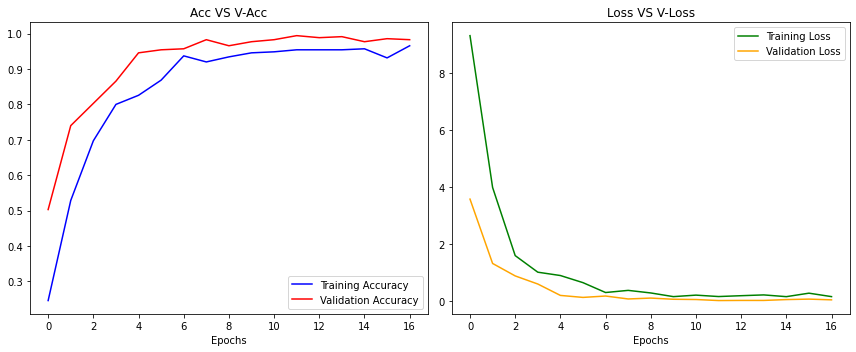

In [52]:
h = hist.history

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'] , c='red', label='Validation Accuracy')
plt.title('Acc VS V-Acc')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(h['loss'], c='green', label='Training Loss')
plt.plot(h['val_loss'] , c="orange", label='Validation Loss')
plt.title('Loss VS V-Loss')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
model = load_model('mood_model.keras')

In [22]:
def preprocess_frame(frame):
  # Resize the frame to the model's expected input size
  resized_frame = cv2.resize(frame, (224, 224))

  # Convert the frame to RGB format (if needed for your model)
  rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

  # Normalize the pixel values (usually between 0 and 1)
  normalized_frame = rgb_frame.astype('float32') / 255.0

  # Expand the dimension for model prediction (add a new axis)
  preprocessed_frame = normalized_frame

  return preprocessed_frame

In [27]:
mood_labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

def capture_and_predict():
  # Initialize camera capture
  cap = cv2.VideoCapture(0)
  font = cv2.FONT_HERSHEY_SIMPLEX  # Font for text overlay

  while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Preprocess frame
    preprocessed_frame = preprocess_frame(frame)

    # Use the loaded model to predict mood
    mood_prediction = model.predict(np.expand_dims(preprocessed_frame, axis=0))
    predicted_index = mood_prediction.argmax(axis=1)[0]  # Get most likely index

    # Get the corresponding mood label based on the index
    predicted_mood = mood_labels[predicted_index]
    mood_text = f"Mood: {predicted_mood}"  # Create text with predicted mood

    # Add text overlay to the frame
    cv2.putText(frame, mood_text, (10, 30), font, 1, (0, 0, 255), 2, cv2.LINE_AA)

    # Display frame with text overlay
    cv2.imshow('Camera', frame)

    # Exit loop on 'q' key press
    if cv2.waitKey(1) == ord('q'):
      break

  # Release capture
  cap.release()
  cv2.destroyAllWindows()


In [28]:
capture_and_predict()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━